# NLP Homework 3. Classical approach and embedding

 ** Author: Talyanskaya Marina **

## Introduction and comments
The initial plan was (and still mostly is):
1. To look at the datasets
2. To clean data (finally managed to do only separately)
3. To apply tfidf as 'classical approch'
4. To apply Word2vec as an example of embedding
5. To apply Random forest and Logistic regression classifiers to both approaches
6. Some tuning
7. Final comments

Note: after looking on dataset I decided to work only with train.tsv as test.tsv provides no signs of classes and I would fail to estimate the work of my classifiers. The sampleSabmission file contained only 2nd class signs that seems to be weird, so, I did as seemed to be logical.

The choice of Random forest and Logregression as classifiers is based on the fact that they both can work with tfidf and word2vec and take relatively little time and computational resources to use.

F1-score metric was chosen due to its ability to take into account not only the number of correct predictions but also a number of missed elements of each class (i.e. includes both precision and recall). As usually, though...


In [16]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics

In [4]:
import zipfile

local_zip = '//jet/prs/workspace/movie-review-sentiment-analysis-kernels-only.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/home/talyanskaya_marina/train_movie_review')
zip_ref.close()

In [5]:
train = pd.read_csv('/home/talyanskaya_marina/train_movie_review/train.tsv', sep="\t")
test = pd.read_csv('/home/talyanskaya_marina/train_movie_review/test.tsv', sep="\t")
sub = pd.read_csv('/home/talyanskaya_marina/train_movie_review/sampleSubmission.csv', sep=",")

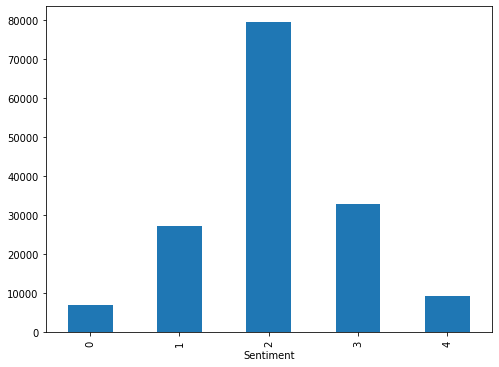

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train.groupby('Sentiment').Phrase.count().plot.bar(ylim=0)
plt.show()

All in all, the classes are imbalanced that may cause some problems...

## Classical approach: tfidf + LogRegression and Random forest

Verctorizing text using classical tfidf approach.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
text_train = train['Phrase']

In [9]:
tfidf=TfidfVectorizer(ngram_range=(1,3),max_df=0.95,min_df=10,sublinear_tf=True, stop_words='english')
trainv =tfidf.fit_transform(text_train)

In [88]:
trainv.shape

(156060, 30560)

In [10]:
y = train['Sentiment']

In [11]:
#Splitting data
X_train, X_test, y_train, y_test = train_test_split(trainv, train.Sentiment, test_size=0.3, random_state = 1000)

In [12]:
#Trying Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
clf_RF_tfidf = RandomForestClassifier()
clf_RF_tfidf.fit(X_train, y_train)
y_rf = clf_RF_tfidf.predict(X_test)

/jet/var/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [92]:
print(metrics.classification_report(y_test, y_rf))

              precision    recall  f1-score   support

           0       0.44      0.37      0.40      2128
           1       0.52      0.46      0.49      8215
           2       0.71      0.79      0.75     23852
           3       0.54      0.48      0.51      9853
           4       0.47      0.40      0.43      2770

    accuracy                           0.63     46818
   macro avg       0.53      0.50      0.52     46818
weighted avg       0.61      0.63      0.62     46818



In [13]:
#Trying Logistic regression classifier
from sklearn.linear_model import LogisticRegression
clf_LR_tfidf = LogisticRegression()
clf_LR_tfidf.fit(X_train, y_train)
y_lr = clf_LR_tfidf.predict(X_test)

/jet/var/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/jet/var/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [17]:
print(metrics.classification_report(y_test, y_lr))

              precision    recall  f1-score   support

           0       0.60      0.16      0.25      2128
           1       0.53      0.29      0.38      8215
           2       0.64      0.90      0.75     23852
           3       0.56      0.42      0.48      9853
           4       0.57      0.20      0.30      2770

    accuracy                           0.62     46818
   macro avg       0.58      0.39      0.43     46818
weighted avg       0.60      0.62      0.58     46818



#### Let's try to tune it: Grid search + cross validation

In [115]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#creation of the parameter grid for Logistic regression
param_grid_LR = {'penalty': ['l1', 'l2'],'C': [0.001, 0.01, 1, 100]}

# looking for best model
tunning_LR = GridSearchCV(clf_LR_tfidf, param_grid_LR, scoring = 'f1_weighted', cv = 5)
tunning_LR.fit(X_train, y_train)

# checking what is the best model
tunning_LR.best_estimator_
print("Parameters:" ,tunning_LR.best_params_)
print("Score:",tunning_LR.best_score_)

In [ ]:
#creation of the parameter grid for Random Forest
param_grid_RF = {'n_estimators:': 10, 100, 500,'max_depth': 10, 100}

# looking for best model
tunning_RF = GridSearchCV(clf_RF_tfidf, param_grid_RF, scoring = 'f1_weighted', cv = 5)
tunning_RF.fit(X_train, y_train)

# checking what is the best model
tunning_RF.best_estimator_
print("Parameters:" ,tunning_RF.best_params_)
print("Score:",tunning_RF.best_score_)

Well, as far as we can see, tuning with Grid Search and cross validation didn't really help our models (and took lots of time...), the best results are still around 0.62-0.63 with F1-score metric (shown by Random forest classifier on tfidf-ed data), that is really poor. An intersting note: it performs relatively ok on 2nd class, it seems to be due to it huge size compared to the others.

## Let's try word2vec...

In [42]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /jet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /jet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /jet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Some data preparation (cleaning)

In [53]:
def clean_sentences(train):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
        #stop words removal
        omit_words = set(stopwords.words('english'))
        words = [x for x in words if x not in omit_words]
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [44]:
#cleaned reviews for train dataset
train_sentences = clean_sentences(train)

  0%|          | 0/156060 [00:00<?, ?it/s]/jet/var/python/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 156060/156060 [04:47<00:00, 543.49it/s]


In [45]:
print(len(train_sentences))

156060


In [95]:
target=train.Sentiment.values

In [96]:
num_features = 180

In [97]:
#Word2vec applying
model_w2v = word2vec.Word2Vec(train_sentences, workers=180, size=num_features, min_count = 35, window = 15, sample = 1e-3)

In [ ]:
model_w2v.init_sims(replace=True)

In [100]:
def createFeatureVector(words, model, num_features):
    featureVector = np.zeros((num_features,),dtype="float32")
    nWords = 0
    index2word_set = set(model_w2v.wv.index2word)
    
    for word in words:
        if word in index2word_set: 
            nWords = nWords + 1.
            featureVector = np.add(featureVector,model[word])
    if(nWords != 0):
        featureVector = np.divide(featureVector,nWords)
    return featureVector

In [ ]:
def averageFeatureVectors(sentences, model, num_features):
    overallFeatureVectors = []
    for sentence in tqdm(sentences):
        overallFeatureVectors.append(createFeatureVector(sentence, model, num_features)) 
    return overallFeatureVectors

In [103]:
train_vect = averagegFeatureVectors(train_sentences, model_w2v, num_features)

  0%|          | 0/156060 [00:00<?, ?it/s]/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
100%|██████████| 156060/156060 [00:36<00:00, 4263.10it/s]


Now we are ready to make some predictions.

In [110]:
#Splitting into train and test sets.
X_train2,X_test2,y_train2,y_test2=train_test_split(train_vect, target, test_size=0.3, stratify=target)

In [111]:
model_rf_w2v = RandomForestClassifier(random_state=100, n_estimators=500, verbose=1, n_jobs=-1, oob_score=True)
model_rf_w2v.fit(X_train2, y_train2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=100, verbose=1,
                       warm_start=False)

In [112]:
from sklearn import metrics
y_rf_w2v = model_rf_w2v.predict(X_test2)
print(metrics.classification_report(y_test2, y_rf_w2v))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s


              precision    recall  f1-score   support

           0       0.45      0.29      0.35      2122
           1       0.51      0.37      0.43      8182
           2       0.66      0.83      0.74     23874
           3       0.53      0.44      0.48      9878
           4       0.50      0.31      0.38      2762

    accuracy                           0.61     46818
   macro avg       0.53      0.45      0.48     46818
weighted avg       0.59      0.61      0.59     46818



[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.7s finished


In [113]:
model_lr_w2v = LogisticRegression()
model_lr_w2v.fit(X_train2, y_train2)
y_lr_w2v = model_lr_w2v.predict(X_test2)

/jet/var/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/jet/var/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [114]:
print(metrics.classification_report(y_test2, y_lr_w2v))

              precision    recall  f1-score   support

           0       0.44      0.01      0.02      2122
           1       0.33      0.03      0.06      8182
           2       0.53      0.94      0.68     23874
           3       0.42      0.15      0.22      9878
           4       0.27      0.01      0.02      2762

    accuracy                           0.52     46818
   macro avg       0.40      0.23      0.20     46818
weighted avg       0.45      0.52      0.41     46818



#### Tuning on Word2vec: Grid search + CV

In [ ]:
#creation of the parameter grid for Logistic regression
param_grid_LR2 = {'penalty': ['l1', 'l2'],'C': [0.001, 0.01, 1, 100]}

# looking for best model
tunning_LR2 = GridSearchCV(model_lr_w2v, param_grid_LR2, scoring = 'f1_weighted', cv = 5)
tunning_LR2.fit(X_train2, y_train2)

# checking what is the best model
tunning_LR2.best_estimator_
print("Parameters:" ,tunning_LR2.best_params_)
print("Score:",tunning_LR2.best_score_)

In [ ]:
#creation of the parameter grid for Random Forest
param_grid_RF2 = {'n_estimators:': 10, 100, 500, 'max_depth': 10, 100}

# looking for best model
tunning_RF2 = GridSearchCV(model_rf_w2v, param_grid_RF, scoring = 'f1_weighted', cv = 5)
tunning_RF2.fit(X_train2, y_train2)

# checking what is the best model
tunning_RF2.best_estimator_
print("Parameters:" ,tunning_RF2.best_params_)
print("Score:",tunning_RF2.best_score_)

Once again, two hours of grid search didn't improve the situtation, the best results are still around 0.6 on F1-score measure (Random forest classifier with n_estimators=500). And again they are very poor and 2nd performed better than the others.

## Final comments

I am not sure if I made it correctly (especially with Word2vec appoach), all in all, it perform pretty bad. The best result was shown by Random Forest Classifier on tf-idf ('classical') approach with 0.63 F1-score, however, the difference is really small (Random Forest on Word2vec was close to 0.6) to argue that the classical approach is really better.
And it still seems I did something wrong, I can't believe it be just a little bit better than random...